In [14]:
"""
This script is designed for forecasting Sri Lankan tourism data using various time series models.
It includes the following functionalities:

- Importing necessary libraries for data manipulation, visualization, and modeling.
- Suppressing warnings for cleaner output.

Libraries Imported:
- pandas: For data manipulation and analysis.
- numpy: For numerical operations.
- matplotlib.pyplot: For data visualization.
- sklearn.metrics.mean_absolute_error: For evaluating model performance.
- sklearn.model_selection.TimeSeriesSplit: For splitting time series data into train/test sets.
- prophet: For forecasting using Facebook's Prophet model.
- statsmodels.tsa.statespace.sarimax.SARIMAX: For SARIMA modeling.
- statsmodels.tsa.holtwinters.ExponentialSmoothing: For Holt-Winters exponential smoothing.
- keras.models.Sequential: For building sequential neural network models.
- keras.layers.LSTM, Dense: For defining LSTM and Dense layers in neural networks.
- sklearn.preprocessing.MinMaxScaler: For scaling data.
- warnings: For managing warnings.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")


In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/dev-achintha/Sri_Lanka-Tourism_Forcasting_Model/working/dataset/2015-2024-monthly-tourist-arrivals-sl-csv.csv')
"""
Reads a CSV file containing monthly tourist arrivals data, processes the data, and returns a cleaned DataFrame.

Steps:
1. Reads the CSV file from the provided URL.
2. Drops the 'PercentageChange' column if it exists.
3. Creates a new datetime column 'ds' by combining 'Year' and 'Month' columns.
4. Renames the 'Arrivals' column to 'y'.
5. Selects only the 'ds' and 'y' columns.
6. Sorts the DataFrame by the 'ds' column.
7. Resets the DataFrame index.

Returns:
    pd.DataFrame: A cleaned DataFrame with columns 'ds' (datetime) and 'y' (tourist arrivals).
"""
df = df.drop(columns=['PercentageChange'], errors='ignore')
df['ds'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')
df.rename(columns={'Arrivals': 'y'}, inplace=True)
df = df[['ds', 'y']]
df.sort_values('ds', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,ds,y
0,2014-01-01,146575
1,2014-02-01,141878
2,2014-03-01,133048
3,2014-04-01,112631
4,2014-05-01,90046


In [16]:
def time_series_cv(model_function, data, initial_train_size, horizon, model_name):
    """
    Perform time series cross-validation.

    Parameters:
    model_function (function): The forecasting model function to be used. It should take two arguments: 
                               the training data and the number of periods to forecast.
    data (pd.DataFrame): The time series data containing 'ds' (date) and 'y' (value) columns.
    initial_train_size (int): The initial number of observations to be used for training.
    horizon (int): The number of periods to forecast in each fold.
    model_name (str): The name of the model, used for logging purposes.

    Returns:
    pd.DataFrame: A DataFrame containing the dates ('ds'), actual values ('Actual'), and predicted values ('Predicted') 
                  for each fold of the cross-validation.
    """

    n_records = len(data)
    n_splits = (n_records - initial_train_size) // horizon
    predictions = []
    actuals = []
    dates = []

    for i in range(n_splits):
        train_end = initial_train_size + i * horizon
        test_end = train_end + horizon

        train_data = data.iloc[:train_end]
        test_data = data.iloc[train_end:test_end]

        # Fit and forecast
        y_pred = model_function(train_data.copy(), len(test_data))

        predictions.extend(y_pred)
        actuals.extend(test_data['y'].values)
        dates.extend(test_data['ds'].values)

        print(f"{model_name} - Fold {i+1}/{n_splits} completed.")

    results = pd.DataFrame({'ds': dates, 'Actual': actuals, 'Predicted': predictions})
    return results

def prophet_model(train_data, periods):
    """
    Trains a Prophet model on the provided training data and forecasts future values.

    Parameters:
    train_data (pd.DataFrame): A DataFrame containing the training data with columns 'ds' for dates and 'y' for values.
    periods (int): The number of periods (months) to forecast into the future.

    Returns:
    np.ndarray: An array of forecasted values for the specified number of periods.
    """

    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False,
                    changepoint_prior_scale=0.1, n_changepoints=30)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(train_data)
    future = model.make_future_dataframe(periods=periods, freq='MS')
    forecast = model.predict(future)
    y_pred = forecast[['ds', 'yhat']].tail(periods)['yhat'].values
    return y_pred

def sarima_model(train_data, periods):
    """
    Fits a SARIMA model to the provided training data and forecasts future values.

    Parameters:
    train_data (pd.DataFrame): A DataFrame containing the time series data with a column 'y' for the values.
    periods (int): The number of periods to forecast into the future.

    Returns:
    np.ndarray: An array containing the forecasted values.
    """

    model = SARIMAX(train_data['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)
    forecast = results.forecast(steps=periods)
    return forecast.values

def exp_smoothing_model(train_data, periods):
    """
    Applies an Exponential Smoothing model to the provided training data and forecasts future values.

    Parameters:
    train_data (pd.DataFrame): A DataFrame containing the training data with a column 'y' representing the time series values.
    periods (int): The number of future periods to forecast.

    Returns:
    np.ndarray: An array of forecasted values for the specified number of periods.
    """
    model = ExponentialSmoothing(train_data['y'], seasonal_periods=12, trend='add', seasonal='add')
    results = model.fit(optimized=True, remove_bias=True)
    forecast = results.forecast(steps=periods)
    return forecast.values

def lstm_model(train_data, periods):
    """
    Trains an LSTM model on the provided training data and forecasts future values.

    Parameters:
    train_data (pd.DataFrame): A DataFrame containing the training data with a column 'y' representing the time series values.
    periods (int): The number of future periods to forecast.

    Returns:
    np.ndarray: An array containing the forecasted values for the specified number of periods.
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(train_data[['y']])

    seq_length = 12  # Using past 12 months

    def create_sequences(data, seq_length):
        sequences = []
        for i in range(len(data) - seq_length):
            sequences.append(data[i:i+seq_length])
        return np.array(sequences)

    X_train = create_sequences(scaled_data, seq_length)
    y_train = scaled_data[seq_length:]

    if len(X_train) == 0:
        y_pred = np.repeat(train_data['y'].iloc[-1], periods)
        return y_pred

    X_train = X_train.reshape((X_train.shape[0], seq_length, 1))

    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Forecasting
    y_pred_scaled = []
    last_sequence = scaled_data[-seq_length:]
    for _ in range(periods):
        X_input = last_sequence.reshape((1, seq_length, 1))
        y_hat = model.predict(X_input, verbose=0)
        y_pred_scaled.append(y_hat[0, 0])
        last_sequence = np.append(last_sequence[1:], y_hat[0, 0])

    y_pred = scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).flatten()
    return y_pred



In [17]:
# Cross-Validation
"""
Performs cross-validation for different time series forecasting models.

Variables:
    initial_train_size (int): The size of the initial training set, calculated as the length of the dataframe minus 24.
    horizon (int): The forecasting horizon, set to 6 months ahead.

Cross-Validation Results:
    prophet_cv_results: Cross-validation results for the Prophet model.
    sarima_cv_results: Cross-validation results for the SARIMA model.
    es_cv_results: Cross-validation results for the Exponential Smoothing model.
    lstm_cv_results: Cross-validation results for the LSTM model.

Functions:
    time_series_cv(model, df, initial_train_size, horizon, model_name): 
        Performs cross-validation for the given model.
        Parameters:
            model: The forecasting model to be evaluated.
            df (DataFrame): The dataframe containing the time series data.
            initial_train_size (int): The size of the initial training set.
            horizon (int): The forecasting horizon.
            model_name (str): The name of the model.
        Returns:
            DataFrame: The cross-validation results for the given model.
"""
initial_train_size = len(df) - 24
horizon = 6 # Forecasting 6 months ahead

# Prophet
prophet_cv_results = time_series_cv(prophet_model, df, initial_train_size, horizon, 'Prophet')

# SARIMA 
sarima_cv_results = time_series_cv(sarima_model, df, initial_train_size, horizon, 'SARIMA')

# Exponential Smoothing 
es_cv_results = time_series_cv(exp_smoothing_model, df, initial_train_size, horizon, 'Exponential Smoothing')

# LSTM
lstm_cv_results = time_series_cv(lstm_model, df, initial_train_size, horizon, 'LSTM')

17:17:14 - cmdstanpy - INFO - Chain [1] start processing
17:17:14 - cmdstanpy - INFO - Chain [1] done processing
17:17:14 - cmdstanpy - INFO - Chain [1] start processing
17:17:14 - cmdstanpy - INFO - Chain [1] done processing


17:17:14 - cmdstanpy - INFO - Chain [1] start processing
17:17:14 - cmdstanpy - INFO - Chain [1] done processing
17:17:14 - cmdstanpy - INFO - Chain [1] start processing


Prophet - Fold 1/4 completed.
Prophet - Fold 2/4 completed.
Prophet - Fold 3/4 completed.


17:17:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet - Fold 4/4 completed.
SARIMA - Fold 1/4 completed.
SARIMA - Fold 2/4 completed.
SARIMA - Fold 3/4 completed.
SARIMA - Fold 4/4 completed.
Exponential Smoothing - Fold 1/4 completed.
Exponential Smoothing - Fold 2/4 completed.
Exponential Smoothing - Fold 3/4 completed.
Exponential Smoothing - Fold 4/4 completed.
LSTM - Fold 1/4 completed.
LSTM - Fold 2/4 completed.
LSTM - Fold 3/4 completed.
LSTM - Fold 4/4 completed.


In [18]:
threshold_date = df['ds'].iloc[initial_train_size - 1]
"""
This script combines the predictions from multiple forecasting models and prints the combined results along with individual model results.

Variables:
    threshold_date (pd.Timestamp): The date corresponding to the end of the initial training period.
    end_of_data_date (pd.Timestamp): The latest date in the dataset.
    combined_dates (pd.Series): The dates for which combined predictions are available.
    combined_pred (pd.Series): The averaged predictions from all models.
    combined_cv_results (pd.DataFrame): DataFrame containing combined dates, combined predictions, and actual values.
    models (dict): Dictionary containing the results of individual models.

DataFrames:
    prophet_cv_results (pd.DataFrame): Cross-validation results for the Prophet model.
    sarima_cv_results (pd.DataFrame): Cross-validation results for the SARIMA model.
    es_cv_results (pd.DataFrame): Cross-validation results for the Exponential Smoothing model.
    lstm_cv_results (pd.DataFrame): Cross-validation results for the LSTM model.

Output:
    Prints the combined predictions and actual values.
    Prints the predictions and actual values for each individual model.
    Prints the threshold date and the end of data date.
"""
end_of_data_date = df['ds'].max()

# Combining Multiple Models
combined_dates = prophet_cv_results['ds']

# Combine predictions averaging
combined_pred = (
    prophet_cv_results['Predicted'] +
    sarima_cv_results['Predicted'] +
    es_cv_results['Predicted'] +
    lstm_cv_results['Predicted']
) / 4

# DataFrame for combined results
combined_cv_results = pd.DataFrame({
    'ds': combined_dates,
    'Predicted': combined_pred,
    'Actual': prophet_cv_results['Actual']  # Assuming all models share the same Actuals
})

# Print combined predictions and actual values
print("Combined Predictions and Actual Values:")
print(combined_cv_results.to_string(index=False))

models = {
    'Prophet': prophet_cv_results,
    'SARIMA': sarima_cv_results,
    'Exponential Smoothing': es_cv_results,
    'LSTM': lstm_cv_results
}

for model_name, results in models.items():
    print(f"\n{model_name} Predictions and Actual Values:")
    print(results.to_string(index=False))

# Print threshold and end of data dates
print(f"\nThreshold Date: {threshold_date}")
print(f"End of Data Date: {end_of_data_date}")


Combined Predictions and Actual Values:
        ds     Predicted  Actual
2022-09-01  17043.884572   29802
2022-10-01  25878.544316   42026
2022-11-01  33348.306358   59759
2022-12-01  79113.526761   91961
2023-01-01  67999.490265  102545
2023-02-01  64550.892263  107639
2023-03-01  80474.961929  125495
2023-04-01  59559.008008  105498
2023-05-01  20777.790109   83309
2023-06-01  38632.924873  100388
2023-07-01  63749.902126  143039
2023-08-01  71502.613802  136405
2023-09-01  99610.166320  111938
2023-10-01 108032.755929  109199
2023-11-01 115271.335449  151496
2023-12-01 162259.602563  210352
2024-01-01 149713.262570  208253
2024-02-01 145059.465115  218350
2024-03-01 174496.324471  209181
2024-04-01 136029.148700  148867
2024-05-01 121158.993067  112128
2024-06-01 124415.466525  113470
2024-07-01 157657.677500  187810
2024-08-01 160998.818704  164609

Prophet Predictions and Actual Values:
        ds  Actual     Predicted
2022-09-01   29802 -17277.418687
2022-10-01   42026   9148.454

In [19]:
# Print the actual data
"""
This script prints the actual data and predictions from various forecasting models including Prophet, SARIMA, Exponential Smoothing, and LSTM.
It also prints the combined forecast and important dates such as the threshold date and the end of data date.

Functions:
- Print the actual data from the dataframe `df`.
- Print individual predictions from:
    - Prophet model (`prophet_cv_results`)
    - SARIMA model (`sarima_cv_results`)
    - Exponential Smoothing model (`es_cv_results`)
    - LSTM model (`lstm_cv_results`)
- Print the combined forecast from `combined_cv_results`.
- Print the threshold date and the end of data date.
"""
print("Actual Data:")
print(df[['ds', 'y']].to_string(index=False))

# Print individual predictions
print("\nProphet Predictions:")
print(prophet_cv_results[['ds', 'Predicted']].to_string(index=False))

print("\nSARIMA Predictions:")
print(sarima_cv_results[['ds', 'Predicted']].to_string(index=False))

print("\nExponential Smoothing Predictions:")
print(es_cv_results[['ds', 'Predicted']].to_string(index=False))

print("\nLSTM Predictions:")
print(lstm_cv_results[['ds', 'Predicted']].to_string(index=False))

# Print combined forecast
print("\nCombined Forecast:")
print(combined_cv_results[['ds', 'Predicted']].to_string(index=False))

# Print threshold and end of data dates
print(f"\nThreshold Date: {threshold_date}")
print(f"End of Data Date: {end_of_data_date}")

Actual Data:
        ds      y
2014-01-01 146575
2014-02-01 141878
2014-03-01 133048
2014-04-01 112631
2014-05-01  90046
2014-06-01 103175
2014-07-01 133971
2014-08-01 140319
2014-09-01 105535
2014-10-01 121576
2014-11-01 119727
2014-12-01 178672
2015-01-01 156246
2015-02-01 165541
2015-03-01 157051
2015-04-01 122217
2015-05-01 113529
2015-06-01 115467
2015-07-01 175804
2015-08-01 166610
2015-09-01 143374
2015-10-01 132280
2015-11-01 144147
2015-12-01 206114
2016-01-01 194280
2016-02-01 197697
2016-03-01 192841
2016-04-01 136367
2016-05-01 125044
2016-06-01 118038
2016-07-01 209351
2016-08-01 186288
2016-09-01 148499
2016-10-01 150419
2016-11-01 167217
2016-12-01 224791
2017-01-01 219360
2017-02-01 197517
2017-03-01 188076
2017-04-01 160249
2017-05-01 121891
2017-06-01 123351
2017-07-01 205482
2017-08-01 190928
2017-09-01 145077
2017-10-01 152429
2017-11-01 167511
2017-12-01 244536
2018-01-01 238924
2018-02-01 235618
2018-03-01 233382
2018-04-01 180429
2018-05-01 129466
2018-06-01 1468

In [20]:
def calculate_mae(cv_results, model_name):
    """
    Calculate and print the Mean Absolute Error (MAE) for a given model's cross-validation results.

    Parameters:
    cv_results (DataFrame): A pandas DataFrame containing the actual and predicted values.
                            It should have columns 'Actual' and 'Predicted'.
    model_name (str): The name of the model for which the MAE is being calculated.

    Returns:
    float: The calculated MAE value.
    """
    mae = mean_absolute_error(cv_results['Actual'], cv_results['Predicted'])
    print(f"MAE for {model_name}: {mae:.2f}")
    return mae

mae_prophet = calculate_mae(prophet_cv_results, 'Prophet')
mae_sarima = calculate_mae(sarima_cv_results, 'SARIMA')
mae_es = calculate_mae(es_cv_results, 'Exponential Smoothing')
mae_lstm = calculate_mae(lstm_cv_results, 'LSTM')

combined_mae = mean_absolute_error(combined_cv_results['Actual'], combined_cv_results['Predicted'])
print(f"MAE for Combined Model: {combined_mae:.2f}")

MAE for Prophet: 79235.70
MAE for SARIMA: 30043.37
MAE for Exponential Smoothing: 33822.78
MAE for LSTM: 36533.75
MAE for Combined Model: 34839.04


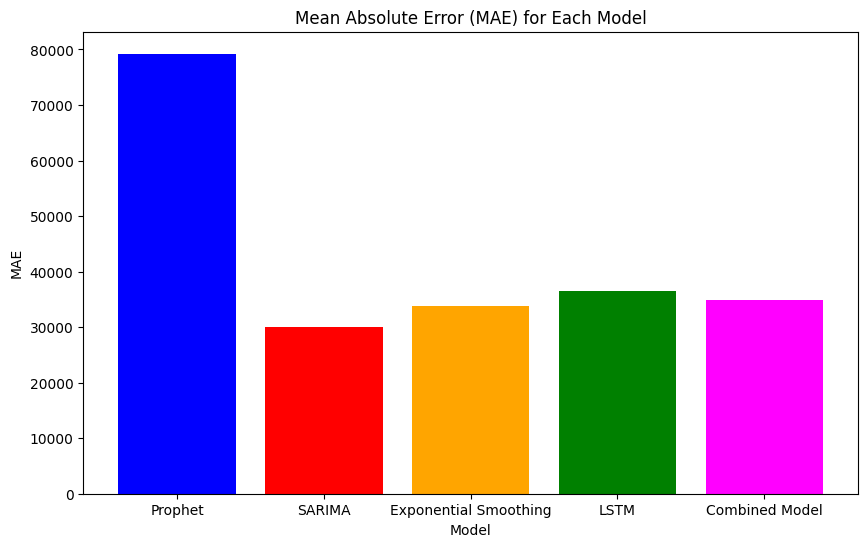

In [21]:
mae_scores = {
    'Prophet': mae_prophet,
    'SARIMA': mae_sarima,
    'Exponential Smoothing': mae_es,
    'LSTM': mae_lstm,
    'Combined Model': combined_mae
}

plt.figure(figsize=(10, 6))
plt.bar(mae_scores.keys(), mae_scores.values(), color=['blue', 'red', 'orange', 'green', 'magenta'])
plt.title('Mean Absolute Error (MAE) for Each Model')
plt.ylabel('MAE')
plt.xlabel('Model')
plt.show()

In [22]:
for model_name, results in models.items():
    """
    Iterates through a dictionary of models, calculates residuals for each model, and prints them.
    Also calculates and prints residuals for a combined model.

    Args:
        models (dict): A dictionary where keys are model names and values are dictionaries containing 'Actual' and 'Predicted' results.
        combined_cv_results (dict): A dictionary containing 'Actual' and 'Predicted' results for the combined model.

    Returns:
        None
    """
    residuals = results['Actual'] - results['Predicted']
    print(f"Residuals of {model_name}:")
    print(residuals.to_string(index=False))
    print("\n")

residuals_combined = combined_cv_results['Actual'] - combined_cv_results['Predicted']
print("Residuals of Combined Model:")
print(residuals_combined.to_string(index=False))


Residuals of Prophet:
 47079.418687
 32877.545910
 55986.976050
  9745.646424
 58120.741308
 82337.117284
 66280.321801
 52243.007557
126308.452673
 85143.428664
111786.162456
 74964.169004
 56744.824731
 30357.722554
 80387.473973
 46323.069595
100943.922553
131200.317341
102717.526634
119650.939424
 87359.314583
 98853.634269
139265.108656
104980.054447


Residuals of SARIMA:
  2815.761828
  8636.243701
  6023.907262
 -5983.423359
  5747.199174
  6074.001185
 26960.180699
 46900.477273
 55975.802815
 68603.183889
 84025.179609
 82787.662432
 -8133.886097
-19173.232430
  4733.630564
 25275.021567
 16377.350994
 24617.298822
 -9778.919166
-38931.966339
-49747.587054
-58809.307441
-23238.509675
-41691.219746


Residuals of Exponential Smoothing:
 28769.636666
 39576.255781
 43680.344380
 17118.099577
 35360.668771
 42725.812478
 34098.165409
 51240.600327
 56919.505951
 66148.500455
 52362.979118
 39985.760233
  5517.646085
  3781.822098
 31637.842728
 37954.881397
 38892.933985
 51466.

In [23]:
# !sudo apt-get update
# !sudo apt-get install -y pandoc texlive-xetex texlive-fonts-recommended texlive-plain-generic
# %pip install jupyter_core jupyter platformdirs pypandoc
!jupyter nbconvert --to pdf /workspaces/Sri_Lanka-Tourism_Forcasting_Model_SARIMA/notebooks/Sri_Lankan_Tourism_Forecasting.ipynb
!jupyter nbconvert --to html /workspaces/Sri_Lanka-Tourism_Forcasting_Model_SARIMA/notebooks/Sri_Lankan_Tourism_Forecasting.ipynb

[NbConvertApp] Converting notebook /workspaces/Sri_Lanka-Tourism_Forcasting_Model_SARIMA/notebooks/Sri_Lankan_Tourism_Forecasting.ipynb to pdf
[NbConvertApp] Support files will be in Sri_Lankan_Tourism_Forecasting_files/
[NbConvertApp] Making directory ./Sri_Lankan_Tourism_Forecasting_files
[NbConvertApp] Writing 77783 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 96849 bytes to /workspaces/Sri_Lanka-Tourism_Forcasting_Model_SARIMA/notebooks/Sri_Lankan_Tourism_Forecasting.pdf
[NbConvertApp] Converting notebook /workspaces/Sri_Lanka-Tourism_Forcasting_Model_SARIMA/notebooks/Sri_Lankan_Tourism_Forecasting.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertA